In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
datasets, info = tfds.load(name='beans', with_info=True, as_supervised=True, split=['train','test','validation'])

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteMV1PGK/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteMV1PGK/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteMV1PGK/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

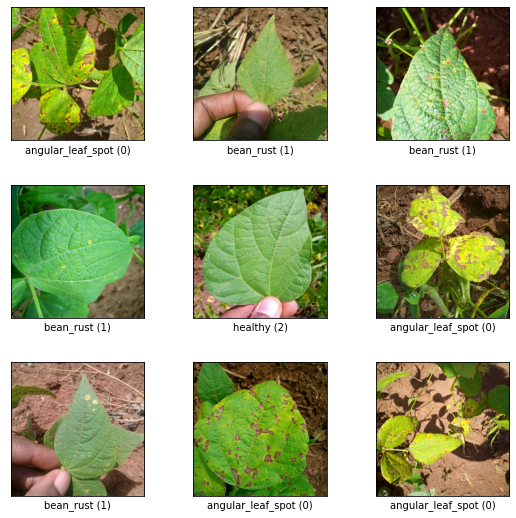

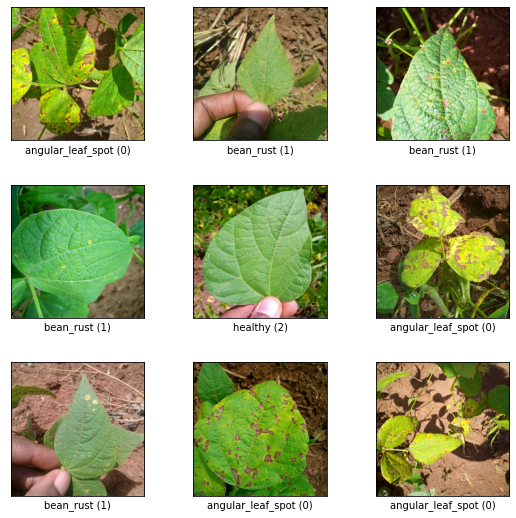

In [ ]:
train, info_train = tfds.load(name='beans', with_info=True, split='test')
tfds.show_examples(info_train,train)

In [ ]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return tf.image.resize(image,[224,224]), tf.one_hot(label, 3)

In [ ]:
def get_dataset(batch_size=32):
  train_dataset_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled = datasets[1].map(scale).batch(batch_size)
  val_dataset_scaled = datasets[2].map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [17]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()


<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [29]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [30]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [32]:
feature_extractor_layer.trainable = False

In [31]:
model = tf.keras.Sequential([feature_extractor_layer, tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(3,activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

In [40]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6066 - acc: 0.9652 - val_loss: 0.6421 - val_acc: 0.9173
Epoch 2/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6056 - acc: 0.9613 - val_loss: 0.6412 - val_acc: 0.9173
Epoch 3/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6095 - acc: 0.9507 - val_loss: 0.6410 - val_acc: 0.9173
Epoch 4/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6125 - acc: 0.9487 - val_loss: 0.6409 - val_acc: 0.9173
Epoch 5/50
33/33 [==============================] - 1s 40ms/step - loss: 0.6093 - acc: 0.9545 - val_loss: 0.6402 - val_acc: 0.9173
Epoch 6/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6070 - acc: 0.9574 - val_loss: 0.6385 - val_acc: 0.9248
Epoch 7/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6049 - acc: 0.9613 - val_loss: 0.6416 - val_acc: 0.9248
Epoch 8/50
33/33 [==============================] - 1s 39ms/step - loss: 0.6072 - a

In [41]:
result = model.evaluate(test_dataset)


4/4 [==============================] - 0s 35ms/step - loss: 0.6550 - acc: 0.8828


[[9.9101651e-01 8.9834835e-03 1.5764247e-08]]


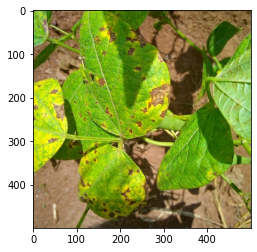

Actual Label: angular_leaf_spot
Predicted Label : angular_leaf_spot
[[8.4225263e-05 9.9986422e-01 5.1528215e-05]]


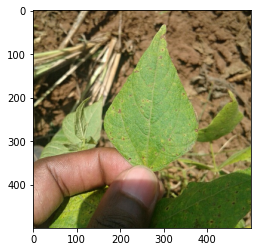

Actual Label: bean_rust
Predicted Label : bean_rust
[[0.5879109  0.40976888 0.0023203 ]]


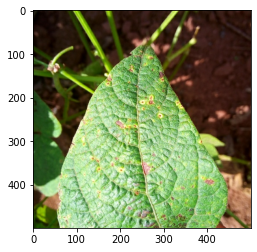

Actual Label: bean_rust
Predicted Label : angular_leaf_spot
[[4.8335243e-04 4.2473685e-02 9.5704299e-01]]


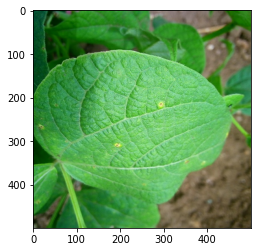

Actual Label: bean_rust
Predicted Label : healthy
[[1.8676559e-07 2.2143735e-05 9.9997771e-01]]


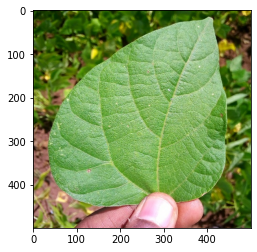

Actual Label: healthy
Predicted Label : healthy
[[9.8398602e-01 1.6000193e-02 1.3670747e-05]]


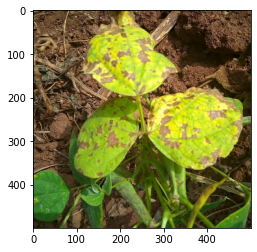

Actual Label: angular_leaf_spot
Predicted Label : angular_leaf_spot
[[1.0186119e-04 9.9952114e-01 3.7703794e-04]]


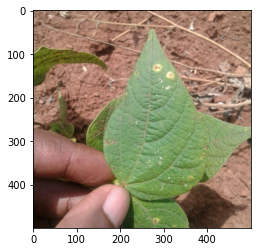

Actual Label: bean_rust
Predicted Label : bean_rust
[[9.9995983e-01 4.0153081e-05 5.7586274e-09]]


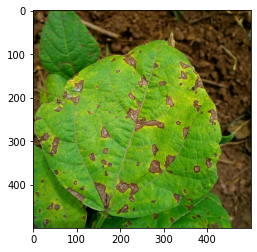

Actual Label: angular_leaf_spot
Predicted Label : angular_leaf_spot
[[9.5345783e-01 4.6534374e-02 7.7165096e-06]]


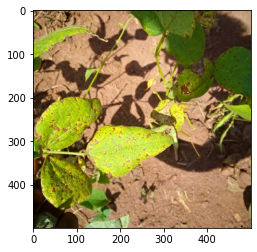

Actual Label: angular_leaf_spot
Predicted Label : angular_leaf_spot
[[3.1718932e-04 9.9754769e-01 2.1351413e-03]]


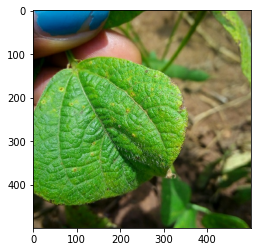

Actual Label: bean_rust
Predicted Label : bean_rust
[[9.984132e-01 9.968600e-04 5.898375e-04]]


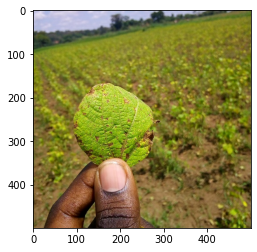

Actual Label: angular_leaf_spot
Predicted Label : angular_leaf_spot
[[9.7674781e-01 2.3251157e-02 1.0916096e-06]]


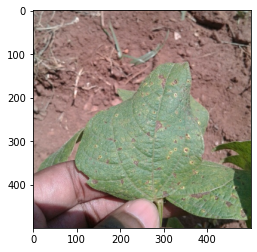

Actual Label: bean_rust
Predicted Label : angular_leaf_spot
[[7.12422747e-03 9.92773473e-01 1.02326696e-04]]


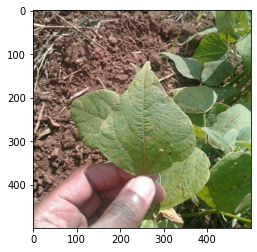

Actual Label: bean_rust
Predicted Label : bean_rust
[[2.2342573e-07 3.0094709e-05 9.9996972e-01]]


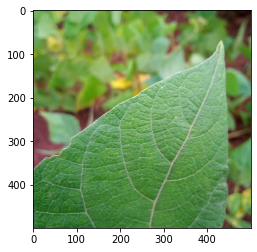

Actual Label: healthy
Predicted Label : healthy
[[0.00244737 0.01119889 0.9863537 ]]


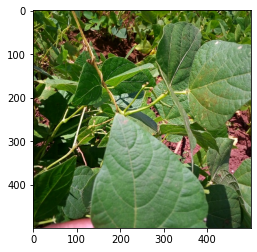

Actual Label: healthy
Predicted Label : healthy
[[0.03187252 0.00853845 0.959589  ]]


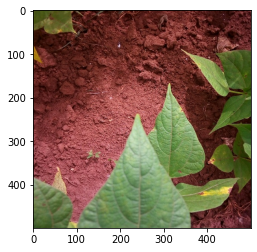

Actual Label: healthy
Predicted Label : healthy
[[7.0075411e-01 2.9924354e-01 2.3401699e-06]]


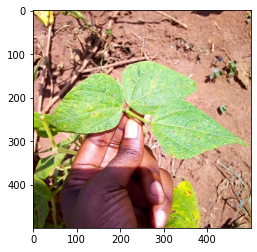

Actual Label: bean_rust
Predicted Label : angular_leaf_spot
[[9.9681371e-01 2.4730936e-03 7.1325427e-04]]


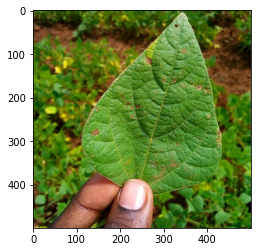

Actual Label: angular_leaf_spot
Predicted Label : angular_leaf_spot
[[5.0801500e-05 1.4815837e-03 9.9846762e-01]]


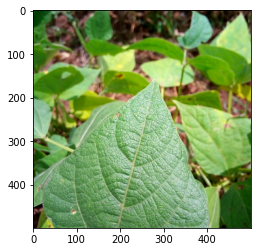

Actual Label: healthy
Predicted Label : healthy
[[0.09801902 0.72455364 0.17742738]]


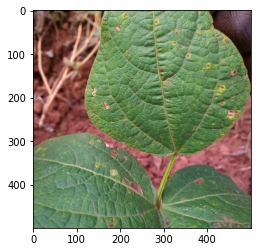

Actual Label: bean_rust
Predicted Label : bean_rust


In [43]:
for test_sample in datasets[1].take(20):
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr= scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)

  img = tf.keras.preprocessing.image.img_to_array(image)
  pred=model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label : %s" % info.features["label"].names[np.argmax(pred)])

In [44]:
for f0,f1 in datasets[1].map(scale).batch(200):
  y=np.argmax(f1, axis=1)
  y_pred=np.argmax(model.predict(f0),axis=1)
  print(tf.math.confusion_matrix(labels=y, predictions=y_pred, num_classes=3))

tf.Tensor(
[[40  3  0]
 [ 8 34  1]
 [ 0  3 39]], shape=(3, 3), dtype=int32)


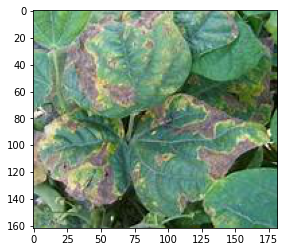

In [62]:
from tensorflow.keras.preprocessing import image
x = image.load_img("/content/th.jpg")
plt.imshow(x)

In [63]:
x = image.img_to_array(x)/255
x.shape

(162, 182, 3)

In [78]:
img = np.expand_dims(x,axis=0)

In [69]:
class_name = ["0","1","2"]